In [1]:
import pathlib
import itertools
import collections
from typing import Dict, List, Union

import matplotlib.pylab as plt
from bokeh.plotting import figure, output_notebook, show
from ipywidgets import interact, interactive, fixed, IntSlider, Dropdown
import torch
import pandas as pd
from PIL import Image
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from dtreeviz.trees import *

from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.torch_core import set_seed

from scheeg import data
from scheeg.performance import accuracy, model_accuracy, sensitivity_specificity_auc

A snippet of code from [fastbook](https://github.com/fastai/fastbook) to draw a decision tree

In [2]:
import graphviz
from sklearn.tree import export_graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

For the sake of reproducibility

In [3]:
set_seed(42)

Some settings for *Pandas*

In [4]:
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

Some colors to be used in LaTeX

In [5]:
latex_colors = {
    'red',
    'Bittersweet',
    'blue',
    'Cerulean',
    'Violet',
    'Goldenrod',
    'ForestGreen',
#     'Gray',
    'YellowOrange',
    'RubineRed',
    'RoyalBlue',
    'Fuchsia',
    'OliveGreen',
    'Black'
}

# Random forests

> Experiments on...

## Parameters

The indexes of the subjects that are reserved for testing

In [6]:
i_testing_subjects = [1, 2]

Those that, during training, will only be used for validation

In [7]:
i_validation_subjects = [3, 4]

The dependent variable is named

In [8]:
dep_var = 'ill'

The number of *folds* when performing cross-validation

In [9]:
n_folds_cross_validation = 7

The path where results are to be saved

In [10]:
output_path = pathlib.Path.home() / 'papers/frontiers_2020/results3'
output_path.mkdir(parents=True, exist_ok=True)
output_path

Path('/home/manu/papers/frontiers_2020/results3')

The names of the EEG channels

In [11]:
eeg_channels_names = [
    'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'C3', 'Cz', 'C4',
    'P3', 'Pz', 'P4', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2']
assert len(eeg_channels_names) == 19

A mapping from indexes to names

In [12]:
eeg_index_to_name = dict(list(enumerate(eeg_channels_names)))

## Data

The path to the MATLAB data file is assembled

In [13]:
input_dir = pathlib.Path.cwd() / 'preprocessed_data'
input_file = input_dir / 'CON_MAT.mat'
assert input_file.exists()
input_file

Path('/home/manu/papers/frontiers_2020/github/preprocessed_data/CON_MAT.mat')

*MATLAB* file is loaded

In [14]:
metrics, (n_subjects, n_channels, _, n_frequency_bands, n_samples) = data.read_matlab(input_file)
print(f'{n_subjects=}, {n_channels=}, {n_frequency_bands=}, {n_samples=}')

n_subjects=14, n_channels=19, n_frequency_bands=50, n_samples=23


It contains arrays

In [15]:
metrics.keys()

dict_keys(['GPDC_H', 'GPDC_S', 'dDTF_H', 'dDTF_S'])

Dimensions are

In [16]:
metrics['GPDC_H'].shape

(14, 19, 19, 50, 23)

*Raw* frequency bands are combined into EEG bands.

In [17]:
eeg_band_from_raw_freq = {
    'delta': range(4),
    'theta': range(4,8),
    'alpha': range(8,12),
    'beta': range(12,30),
    'gamma': range(30,50)
}

A convenience function to write a connectivity matrix in a format suitable to be plot by *pgfplots* as a heatmap.

In [18]:
def connectivity_matrix_to_pgf(matrix: np.ndarray, output_file: Union[str, pathlib.Path], meta:str = '') -> None:

    # header
    with output_file.open('w') as f:
        f.write(f'# {meta}\n')
        f.write(f'# <source channel> <destination channel> <metric>\n')

    # data
    with output_file.open('a') as f:
        for i_coord, coord in enumerate(itertools.product(np.arange(n_channels), repeat=2), start=1):
            f.write(f'{coord[1]} {coord[0]} {matrix[coord[1],coord[0]]}\n')

            # a newline every time a column is processed
            if i_coord % n_channels == 0:
                f.write('\n')

We write files for ill and healthy subjects using the above function.

In [19]:
# for k, meta, output in zip(['GPDC_S'], ['GPDC, alpha band, ill subject #0, sample #0'], ['connectivity_ill.txt']):
for k, meta, output in zip(
    ['GPDC_S', 'GPDC_H'],
    ['GPDC, alpha band, ill subject #0, sample #0', 'GPDC, alpha band, healthy subject #0, sample #0'],
    ['connectivity_ill.txt', 'connectivity_healthy.txt']):
    averaged_freqs = data.average_frequencies(metrics[k], eeg_band_from_raw_freq.values())
    connectivity_matrix_example = averaged_freqs[0, ..., 2, 0]
    connectivity_matrix_to_pgf(connectivity_matrix_example, output_path / output, meta)

After averaging over frequencies, these are the dimensions of the resulting arrays

In [20]:
averaged_freqs.shape

(14, 19, 19, 5, 23)

Ultimately, the dimensions of a *single* connectiviy matrix are

In [21]:
connectivity_matrix_example.shape

(19, 19)

### Pre-processing

A function to build a `DataFrame` from *healthy* and *ill* samples for a given metric.

In [22]:
def metric_to_df(healthy: np.array, ill: np.array, columns_name_prefix: str, dep_var: str = 'ill') -> pd.DataFrame:
    
    pre_processed_data = [
        data.to_df(
            *data.images_to_vectors(
                data.average_frequencies(array, eeg_band_from_raw_freq.values()),
                both=True, name_prefix=columns_name_prefix
            )
        )
        for array in [healthy, ill]
    ]
    
    pre_processed_data[0][dep_var] = False
    pre_processed_data[1][dep_var] = True
    
    return pd.concat(pre_processed_data, axis=0)

#### GPDC

The above function is applied on *GPDC* metric

In [23]:
df_GPDC = metric_to_df(metrics['GPDC_H'], metrics['GPDC_S'], columns_name_prefix='GPDC_', dep_var=dep_var)
df_GPDC.head()

,f0_GPDC_1->2,f0_GPDC_1->3,f0_GPDC_1->4,f0_GPDC_1->5,...,f4_GPDC_19->17,f4_GPDC_19->18,subject,ill
0,0.193671,0.136767,0.223983,0.097557,...,0.148518,0.107629,0,False
1,0.207843,0.207882,0.052576,0.039825,...,0.160711,0.118167,0,False
2,0.298257,0.199198,0.146058,0.189476,...,0.159271,0.132362,0,False
3,0.327883,0.129152,0.101264,0.140192,...,0.137271,0.106552,0,False
4,0.257698,0.219826,0.149464,0.113010,...,0.153047,0.135164,0,False


The number of features is

In [24]:
df_GPDC.shape[1] - 2

1710

Subjects are

In [25]:
df_GPDC['subject'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

Notice that every *subject* above actually **encompasses two different subjects** since we have `n_subjects` healthy subjects and `n_subjects` ill ones, and they are labeled the same. In other words, the $n$-th subject encompasses the samples of the $n$-th healthy subject and those of the $n$-th ill subject. Hence, the number of samples for the, e.g., $0$-th *subject* is twice the number of actual samples we have for any given subject.

In [26]:
assert df_GPDC.groupby('subject').size().loc[0] == n_samples * 2

The above remark entails that we have the same number of *healthy* and *ill* labels.

In [27]:
df_GPDC[dep_var].value_counts()

False    322
True     322
Name: ill, dtype: int64

#### dDTF

In [28]:
df_dDTF = metric_to_df(metrics['dDTF_H'], metrics['dDTF_S'], columns_name_prefix='dDTF_', dep_var=dep_var)
df_dDTF.head()

,f0_dDTF_1->2,f0_dDTF_1->3,f0_dDTF_1->4,f0_dDTF_1->5,...,f4_dDTF_19->17,f4_dDTF_19->18,subject,ill
0,0.019290,0.003358,0.003562,0.002336,...,0.000031,0.000118,0,False
1,0.021730,0.002265,0.001473,0.000837,...,0.000061,0.000095,0,False
2,0.044746,0.002445,0.000355,0.005867,...,0.000062,0.000079,0,False
3,0.046227,0.002385,0.001360,0.001562,...,0.000069,0.000120,0,False
4,0.034626,0.006564,0.002240,0.001680,...,0.000054,0.000220,0,False


**CAVEAT**: notice that every *subject* in the `DataFrame` actually encompasses data from two subjects, one healthy and one sick. Moreover, this (arbitrary) pairing of subjects affects data splitting below.

#### Both metrics

In [29]:
# `ill` columns are the same in both `DataFrame`s
assert df_GPDC['ill'].equals(df_dDTF['ill'])

# idem for `subject`
assert df_GPDC['subject'].equals(df_dDTF['subject'])

# we get rid of those in, e.g., `df_GPDC`, before concatenating
df = pd.concat((df_GPDC.drop(['ill', 'subject'], axis=1), df_dDTF), axis=1)
df.shape

(644, 3422)

In [30]:
df.head()

,f0_GPDC_1->2,f0_GPDC_1->3,f0_GPDC_1->4,f0_GPDC_1->5,...,f4_dDTF_19->17,f4_dDTF_19->18,subject,ill
0,0.193671,0.136767,0.223983,0.097557,...,0.000031,0.000118,0,False
1,0.207843,0.207882,0.052576,0.039825,...,0.000061,0.000095,0,False
2,0.298257,0.199198,0.146058,0.189476,...,0.000062,0.000079,0,False
3,0.327883,0.129152,0.101264,0.140192,...,0.000069,0.000120,0,False
4,0.257698,0.219826,0.149464,0.113010,...,0.000054,0.000220,0,False


The indexes in the concatenated `DataFrame`s were the same, and so we have duplicated labels

In [31]:
df.index.nunique()

322

We make a new index

In [32]:
df = df.reset_index(drop=True)

The number of features is

In [33]:
df.shape[1] - 2

3420

## Splitting the data into training and validation sets

A function to split the data into training and validation according to the indexes of *paired* subjects. That is, subject #3 means healthy subject #3 and ill subject #3.

In [34]:
def split_data_on_paired_subjects(df: pd.DataFrame, i_validation_subjects: list) -> Tuple[list, list]:
    
    belong_in_validation = df['subject'].isin(i_validation_subjects)
    i_validation = np.where(belong_in_validation)[0]
    i_training = np.where(~belong_in_validation)[0]
    
    return sorted(i_training), sorted(i_validation)

An example run

In [35]:
i_training, i_validation = split_data_on_paired_subjects(df, [0])
i_training[:4], i_validation[:4]

([23, 24, 25, 26], [0, 1, 2, 3])

The number of samples in the training and validation sets. The latter must be `n_samples` $\times$ $2$ subjects (one healthy, and ill) $\times$ `len(i_validation_subjects)`.

In [36]:
len(i_training), len(i_validation)

(598, 46)

A function to split the data considering separately healthy and ill subjects.

In [37]:
def split_data_on_individual_subjects(
    df: pd.DataFrame, i_healthy_subjects_in_valid: list, i_ill_subjects_in_valid: list) -> Tuple[list, list]:
    
    healthy_in_validation = (df['subject'].isin(i_healthy_subjects_in_valid)) & (~ df['ill'])
    ill_in_validation = (df['subject'].isin(i_ill_subjects_in_valid)) & df['ill']
    
    i_validation = np.nonzero((healthy_in_validation | ill_in_validation).to_numpy())[0].tolist()
    i_training = list(set(range(len(df))) - set(i_validation))
    
    assert len(df) == len(i_validation) + len(i_training)
    
    return sorted(i_training), sorted(i_validation)

An arbitrary example

In [38]:
i_training, i_validation = split_data_on_individual_subjects(df, [0, 1], [1])

In [39]:
i_training[:4], i_validation[:4]

([46, 47, 48, 49], [0, 1, 2, 3])

The number of samples in the training and validation sets. The latter must be `n_samples` $\times$ (`len(i_healthy_subjects_in_valid)` + `len(i_ill_subjects_in_valid)`).

In [40]:
len(i_training), len(i_validation)

(575, 69)

## Machine Learning

Subjects in `i_testing_subjects` are excluded from the training data

In [41]:
df_training = df.loc[~df['subject'].isin(i_testing_subjects)]
df_training

,f0_GPDC_1->2,f0_GPDC_1->3,f0_GPDC_1->4,f0_GPDC_1->5,...,f4_dDTF_19->17,f4_dDTF_19->18,subject,ill
0,0.193671,0.136767,0.223983,0.097557,...,0.000031,0.000118,0,False
1,0.207843,0.207882,0.052576,0.039825,...,0.000061,0.000095,0,False
2,0.298257,0.199198,0.146058,0.189476,...,0.000062,0.000079,0,False
3,0.327883,0.129152,0.101264,0.140192,...,0.000069,0.000120,0,False
4,0.257698,0.219826,0.149464,0.113010,...,0.000054,0.000220,0,False
...,...,...,...,...,...,...,...,...,...
639,0.200023,0.152216,0.059465,0.042155,...,0.000079,0.000470,13,True
640,0.130879,0.057998,0.019935,0.100413,...,0.000090,0.000534,13,True
641,0.113488,0.052979,0.036449,0.074418,...,0.000136,0.000471,13,True
642,0.156734,0.104146,0.057309,0.129024,...,0.000176,0.000315,13,True


Number of ill and healthy subjects

In [42]:
df_training[dep_var].value_counts()

False    276
True     276
Name: ill, dtype: int64

Indexes for the training and validation sets

In [43]:
i_training, i_validation = split_data_on_paired_subjects(df_training, i_validation_subjects)

The sum of samples in *training* and *validation* brings back the original size.

In [44]:
assert (len(i_validation) + len(i_training)) == len(df_training)

Also, the indexes are disjoint

In [45]:
assert set(i_validation).intersection(i_training) == set()

The *data columns* (as opposed to the *outcome column* or the *subject column*) can be identified because they contain numbers.

In [46]:
data_columns = df.filter(regex=r'\d+').columns.to_list()
data_columns[:4]

['f0_GPDC_1->2', 'f0_GPDC_1->3', 'f0_GPDC_1->4', 'f0_GPDC_1->5']

A fastai *tabular object*

In [47]:
to = TabularPandas(df_training, cont_names=data_columns, y_names=dep_var, splits=(i_training, i_validation))
type(to)

fastai.tabular.core.TabularPandas

Number of samples in the *training* and *validation* sets

In [48]:
len(to.train), len(to.valid)

(460, 92)

First few samples

In [49]:
to.show(3)

For the sake of convenience, we set variables for easy access to the independent and dependent variables in both the *training* and *validation* sets

In [50]:
xs, y = to.train.xs,to.train.y
valid_xs, valid_y = to.valid.xs,to.valid.y

## Simple decision tree

In [51]:
model = DecisionTreeClassifier(max_leaf_nodes=4)
model.fit(xs, y);

The resulting tree is drawn. Notice that we are renaming the columns so that [graphviz](https://graphviz.org/) (on which `draw_tree` relies) doesn't get confused.

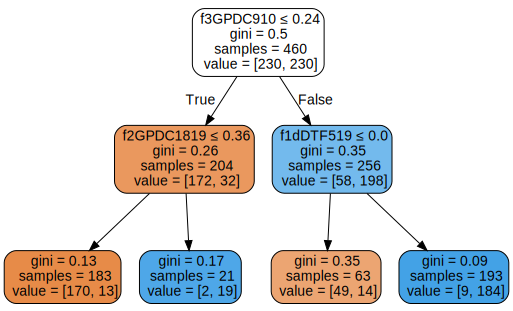

In [52]:
draw_tree(
    model, xs.rename(lambda x: x.replace('->', '').replace('_', ''), axis='columns'), leaves_parallel=True, precision=2)

In [53]:
model

DecisionTreeClassifier(max_leaf_nodes=4)

Another fit with different hyperparameters

In [54]:
model = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
model.fit(xs, y);

How many leaves result? Is that a lot relative to the size of the dataset?

In [55]:
model.get_n_leaves(), len(xs)

(13, 460)

Notice that the model is **classifier** (rather than a regressor), and hence it predicts integers.

In [56]:
model.predict(valid_xs).dtype

dtype('int8')

However, it is possible to estimate the probability of each class

In [57]:
model.predict_proba(valid_xs)[10:15]

array([[1.   , 0.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.875, 0.125]])

The corresponding *decisions* are

In [58]:
model.predict(valid_xs)[10:15]

array([0, 1, 0, 0, 0], dtype=int8)

These are the classes (and hence the probability of a subject being *ill* is in the 2nd column)

In [59]:
model.classes_

array([0, 1], dtype=int8)

Accuracy on training and validation

In [60]:
model_accuracy(model, xs, y), model_accuracy(model, valid_xs, valid_y)

(0.9782608695652174, 0.5)

## Random forests

A simple *random forest regressor* with default settings

In [61]:
model = RandomForestRegressor()
model.fit(xs, y);

*Training* and *validation* accuracy

In [62]:
model_accuracy(model, xs, y), model_accuracy(model, valid_xs, valid_y)

(0.15217391304347827, 0.0)

A convenience function to build and fit in one go a *random forest*. It returns the fitted model.

In [63]:
def rf(xs, y, n_estimators=200, max_samples=None,
       max_features=0.025, min_samples_leaf=10):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_features=max_features, max_samples=max_samples,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [64]:
model = rf(xs, y);

In [65]:
model_accuracy(model, xs, y), model_accuracy(model, valid_xs, valid_y)

(0.9956521739130435, 0.8695652173913043)

Out-of-bag (OOB) predictions are much better

In [66]:
# accuracy(model.oob_prediction_,y)

The prediction for every sample (in the *validation* set) from each individual tree

In [67]:
all_trees_predictions = np.stack([m.predict(valid_xs) for m in model.estimators_])
all_trees_predictions.shape

(200, 92)

The above validation accuracy is simply the mean across all the tress

In [68]:
accuracy(all_trees_predictions.mean(0), valid_y)

0.0

The standard deviation across tress

In [69]:
sds = all_trees_predictions.std(axis=0)
sds.min(), sds.max()

(0.3619046835839523, 0.49997499937496886)

Prediction as we increase the number of trees

In [70]:
n_trees = all_trees_predictions.shape[0]
n_trees_accuracy = np.array(
    [accuracy(all_trees_predictions[:i+1].mean(axis=0), valid_y) for i in range(n_trees)])

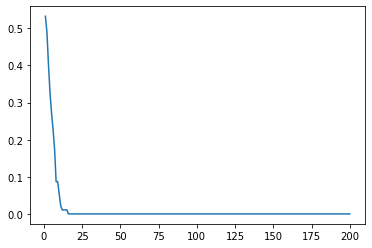

In [71]:
plt.plot(np.arange(1, n_trees+1), n_trees_accuracy);

## Automating the above process

A convenience function to split the data into *training*, *validation* and *testing* datasets, and fit a random forest to the first one.

In [72]:
def split_data_and_fit(df: pd.DataFrame, i_testing_subjects: list, i_validation_subjects: list):

    # the names of the columns, which are NOT the dependent variable
    data_columns = df.filter(regex=r'\d+').columns.to_list()

    # training data is filtered out of the full dataset
    df_training = df.loc[~df['subject'].isin(i_testing_subjects)]
    
    i_training, i_validation = split_data_on_paired_subjects(df_training, i_validation_subjects)

    # fastai data object
    to = TabularPandas(df_training, cont_names=data_columns, y_names=dep_var, splits=(i_training, i_validation))

    # the model is built and fitted
    model = rf(to.train.xs, to.train.y)

    return model, to

## Feature importance

A convenience function to combine the names and importance (according to the random forest) of the different features into a pandas `Series`

In [73]:
def feature_importance_series(model, xs) -> pd.Series:
    
    return pd.Series(data=model.feature_importances_, index=xs.columns).sort_values(ascending=False)

In [74]:
fi = feature_importance_series(model, xs)
fi.head()

f3_GPDC_9->10     0.023309
f4_GPDC_9->10     0.023262
f4_GPDC_14->15    0.021295
f3_dDTF_15->8     0.020003
f1_dDTF_5->19     0.016552
dtype: float64

Worst features are

In [75]:
fi.sort_values()[:30]

f1_GPDC_10->2     0.0
f3_dDTF_13->8     0.0
f3_dDTF_13->7     0.0
f3_dDTF_13->6     0.0
f3_dDTF_13->5     0.0
                 ... 
f3_dDTF_13->11    0.0
f3_dDTF_13->12    0.0
f3_dDTF_15->3     0.0
f0_GPDC_11->1     0.0
f3_dDTF_14->10    0.0
Length: 30, dtype: float64

It can be seen there is a mixture of *GPDC* and *dTFT* features.

In [76]:
print(f'{(fi > 0).sum()} features (out of {len(fi)}) contribute something')

1274 features (out of 3420) contribute something


Let us set a threshold,

In [77]:
# threshold = 5e-3
threshold = 1e-3

and keep only those features whose importance is above it

In [78]:
feature_above_threshold = fi > threshold
feature_above_threshold.sum()

227

In [79]:
important_features = fi[feature_above_threshold]
important_features.head()

f3_GPDC_9->10     0.023309
f4_GPDC_9->10     0.023262
f4_GPDC_14->15    0.021295
f3_dDTF_15->8     0.020003
f1_dDTF_5->19     0.016552
dtype: float64

In [80]:
xs_important = xs[important_features.index]
xs_important.head()

,f3_GPDC_9->10,f4_GPDC_9->10,f4_GPDC_14->15,f3_dDTF_15->8,...,f3_GPDC_19->8,f1_dDTF_5->16,f2_dDTF_7->8,f3_dDTF_18->16
0,0.249472,0.186552,0.151434,0.018941,...,0.075815,0.001085,0.002103,0.000677
1,0.219307,0.168964,0.122277,0.014115,...,0.116476,0.000770,0.003273,0.001814
2,0.239482,0.174679,0.161544,0.012812,...,0.125045,0.000783,0.003199,0.002590
3,0.243696,0.193587,0.158045,0.009962,...,0.108608,0.001427,0.002469,0.002397
4,0.165699,0.150259,0.146735,0.010890,...,0.077091,0.001631,0.003309,0.003666


In [81]:
model = rf(xs_important, y);
model_accuracy(model, xs_important, y), model_accuracy(model, valid_xs[important_features.index], valid_y)

(0.9956521739130435, 0.8804347826086957)

So, nothing really changed by dismissing quite a bunch of features, specifically,

In [82]:
xs.shape[1] - xs_important.shape[1]

3193

### Selecting the best features

A function that gives the accuracy when using the *best $n$ features* for every possible value of $n$

In [83]:
def accuracy_for_n_best_features(
    feature_importance: pd.Series, xs: pd.DataFrame, y: pd.Series, valid_xs: pd.DataFrame, valid_y: pd.Series
) -> pd.Series:
    
    n_features = len(feature_importance)
    
    acc = np.empty(n_features)
    
    for n_features_minus_1 in range(n_features):
        
        to_keep = feature_importance.iloc[:n_features_minus_1+1].index

        # a model with only the relevant features
        model = rf(xs[to_keep], y)
        
        acc[n_features_minus_1] = model_accuracy(model, valid_xs[to_keep], valid_y)
    
    return pd.Series(acc, index=range(1, 1+n_features))

The *aggregated* importance of the features is used

In [84]:
%%script false --no-raise-error
n_best_feactures_accuracy = accuracy_for_n_best_features(fi, xs, y, valid_xs, valid_y)
n_best_feactures_accuracy

In [85]:
%%script false --no-raise-error
n_best_feactures_accuracy[:50].plot();

It seems beyond a few dozens of features, there is not much to be gained.

### Impact on performance of the feature importance threshold

A function to assess the performance when dismissing those features whose performance is below a certain threshold

In [86]:
def importance_threshold_to_accuracy(
    feature_importance: pd.Series, threshold: float, xs: pd.DataFrame, y: pd.Series, valid_xs: pd.DataFrame,
    valid_y: pd.Series) -> float:
    
    # `True` for those features whose importance is above the treshold
    feature_above_threshold = feature_importance >= threshold
    
    # their names are elicited
    important_features = fi[feature_above_threshold].index
    
    # a new `DataFrame` for training with only the most important features
    xs_important = xs[important_features]
    
    # a model with only the relevant features
    model = rf(xs_important, y)
    
    # accuracy on the validation set
    return model_accuracy(model, valid_xs[important_features], valid_y)

In [87]:
max_importance = fi.iloc[0].item()
max_importance

0.023308680725368

Using only the best feature

In [88]:
importance_threshold_to_accuracy(fi, max_importance, xs, y, valid_xs, valid_y)

0.33695652173913043

Over a range of thresholds

In [89]:
# thresholds = np.linspace(max_importance / 1_000, max_importance, 10)
thresholds = np.arange(1e-3, max_importance, 5e-3)
threshold_accuracy = [importance_threshold_to_accuracy(fi, t, xs, y, valid_xs, valid_y) for t in thresholds]
threshold_n_features = (fi.values[np.newaxis, :] > thresholds[:, np.newaxis]).sum(axis=1)
threshold_accuracy_df = pd.DataFrame(
    np.c_[thresholds, threshold_accuracy, threshold_n_features],
    columns=['threshold', 'accuracy', 'n_features']
).astype({'n_features': int})
threshold_accuracy_df

,threshold,accuracy,n_features
0,0.001,0.891304,227
1,0.006,0.739130,27
2,0.011,0.576087,9
3,0.016,0.543478,5
4,0.021,0.358696,3


We can plot the *accuracy* against the *threshold*

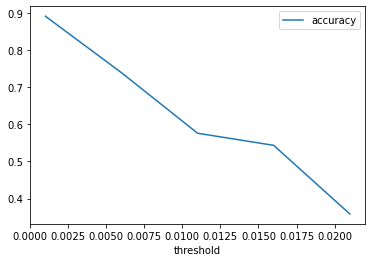

In [90]:
threshold_accuracy_df.plot(x='threshold', y='accuracy');

Notice that a lower threshold (left part of the plot) entails more features being used.

### Variability on features importance

A convenience function to estimate *feature importance* for a given split of the data.

In [91]:
def split_data_and_compute_feature_importance(i_testing_subjects: list, i_validation_subjects: list) -> pd.Series:

    model, to = split_data_and_fit(df, i_testing_subjects, i_validation_subjects)

    # a Pandas series with the importance of every feature
    return feature_importance_series(model, to.xs)

With the same data splitting considered so far

In [92]:
fi_1 = split_data_and_compute_feature_importance(i_testing_subjects, i_validation_subjects)
fi_1

f0_dDTF_19->5     0.025174
f3_dDTF_15->8     0.023419
f1_GPDC_18->19    0.018179
f2_GPDC_18->19    0.018027
f3_GPDC_9->10     0.017941
                    ...   
f4_GPDC_3->6      0.000000
f4_GPDC_3->8      0.000000
f4_GPDC_3->9      0.000000
f4_GPDC_3->10     0.000000
f4_dDTF_19->18    0.000000
Length: 3420, dtype: float64

With a different data split

In [93]:
fi_2 = split_data_and_compute_feature_importance([0, 1], [2, 3])
fi_2

f3_dDTF_15->8     0.025125
f0_GPDC_1->6      0.024355
f1_dDTF_12->13    0.018151
f3_dDTF_15->19    0.017059
f2_dDTF_12->13    0.012320
                    ...   
f4_GPDC_4->17     0.000000
f4_GPDC_4->18     0.000000
f4_GPDC_5->6      0.000000
f4_GPDC_5->9      0.000000
f4_dDTF_19->18    0.000000
Length: 3420, dtype: float64

Both results are assembled in a single `DataFrame` (properly pairing together values referred to the same feature)

In [94]:
fi_df = pd.concat((fi_1, fi_2), axis=1)
fi_df.head()

,0,1
f0_dDTF_19->5,0.025174,0.010780
f3_dDTF_15->8,0.023419,0.025125
f1_GPDC_18->19,0.018179,0.007534
f2_GPDC_18->19,0.018027,0.004300
f3_GPDC_9->10,0.017941,0.006985


The most *overall* important features when considering the two splits

In [95]:
fi_df.sum(axis=1).sort_values(ascending=False)

f3_dDTF_15->8     0.048544
f0_dDTF_19->5     0.035954
f0_GPDC_1->6      0.029216
f4_GPDC_9->10     0.026557
f1_GPDC_18->19    0.025713
                    ...   
f2_GPDC_1->10     0.000000
f2_GPDC_1->9      0.000000
f2_GPDC_1->4      0.000000
f1_GPDC_19->15    0.000000
f4_dDTF_19->18    0.000000
Length: 3420, dtype: float64

We compute the *features importance* for every possible data split of the *training* set into *training* and *validation*, while excluding the *testing* subjects.

In [96]:
fis = [
    split_data_and_compute_feature_importance(i_testing_subjects, list(i_valid))
    for i_valid in itertools.combinations(range(12), 2)
]

In [97]:
fis_df = pd.concat(fis, axis=1)
fis_df.head()

,0,1,2,3,...,62,63,64,65
f3_dDTF_15->19,0.020984,0.016534,0.014190,0.007127,...,0.014892,0.002675,0.005316,0.010920
f3_dDTF_18->8,0.020635,0.011457,0.007800,0.006119,...,0.005946,0.010898,0.006047,0.005407
f3_dDTF_15->8,0.019843,0.025174,0.015058,0.019630,...,0.015839,0.021260,0.007981,0.027771
f1_GPDC_1->6,0.019738,0.007604,0.009759,0.014054,...,0.001536,0.001314,0.000000,0.002785
f0_dDTF_19->5,0.016404,0.007058,0.012488,0.025153,...,0.003519,0.010396,0.011736,0.003955


Again, the most *overall* important features

In [98]:
fis_df.sum(axis=1).sort_values(ascending=False)[:20]

f3_dDTF_15->8     1.181074
f1_dDTF_5->19     0.894932
f1_dDTF_12->13    0.841426
f2_dDTF_12->13    0.763578
f4_GPDC_9->10     0.710758
f3_dDTF_18->8     0.635532
f2_GPDC_18->19    0.627510
f1_GPDC_18->19    0.618814
f1_dDTF_19->5     0.617623
f3_dDTF_15->19    0.608419
f2_GPDC_8->13     0.595927
f0_dDTF_19->5     0.588915
f4_GPDC_18->9     0.560712
f0_GPDC_1->6      0.533647
f1_GPDC_8->13     0.526032
f1_GPDC_9->13     0.472138
f4_dDTF_14->8     0.441425
f3_GPDC_9->10     0.440868
f1_dDTF_18->17    0.415286
f3_dDTF_12->13    0.408053
dtype: float64

The top features are not the same as before, but those that were important before (*GPDC* $116$ and $156$, *dDTF* $79$...) still are.

Besides the mean, we can also compute the standard deviation

In [99]:
fis_df.std(axis=1).sort_values(ascending=False)

f4_GPDC_18->9     0.007519
f3_GPDC_9->10     0.006558
f1_dDTF_5->19     0.006321
f2_GPDC_18->19    0.006230
f1_GPDC_8->13     0.006138
                    ...   
f3_GPDC_5->11     0.000007
f3_GPDC_3->17     0.000006
f0_GPDC_7->10     0.000005
f0_dDTF_14->19    0.000004
f3_GPDC_15->1     0.000003
Length: 3420, dtype: float64

Standard deviations are pretty small relative to the means.

### Another take

A function to split the data on individual subjects (as opposed to *paired* subjects) and fit the model.

In [100]:
def split_data_on_individual_subjects_and_fit(
    df: pd.DataFrame, i_healthy_subjects_in_valid: list, i_ill_subjects_in_valid: list):

    # the names of the columns, which are NOT the dependent variable
    data_columns = df.filter(regex=r'\d+').columns.to_list()
    
    i_training, i_validation = split_data_on_individual_subjects(
        df, i_healthy_subjects_in_valid, i_ill_subjects_in_valid)

    # fastai data object
    to = TabularPandas(df, cont_names=data_columns, y_names=dep_var, splits=(i_training, i_validation))

    # the model is built and fitted
    model = rf(to.train.xs, to.train.y)

    return model, to

A new function that encapsulates the application of the above function on every combination of *individual* subjects for `i_healthy_subjects_in_valid` and `i_ill_subjects_in_valid`. The names of the columns in the resulting `DataFrame` indicate the index of the healthy subject and that of the ill one.

In [101]:
def fi_individual_combinations():
    
    series = []
    names = []

    for i_healthy, i_ill in itertools.product(range(n_subjects), repeat=2):

        # split and fitting
        m, t = split_data_on_individual_subjects_and_fit(df, [i_healthy], [i_ill])

        # results are recorded
        series.append(feature_importance_series(m, t.xs))
        names.append(f'{i_healthy}H{i_ill}I')

    df_fi = pd.concat(series, axis=1)
    df_fi.columns = names
    
    return df_fi

In [102]:
%%script false --no-raise-error
df_fi = fi_individual_combinations()
df_fi

On average

In [103]:
%%script false --no-raise-error
average_fi = df_fi.mean(axis=1).sort_values(ascending=False)
average_fi

## Performance

A *sub*directory for the results

In [104]:
subject_aware_output_path = output_path / 'subject_aware'
subject_aware_output_path.mkdir(exist_ok=True)

For the sake of convenience, a `DataFrame` focused only on subjects and whether or not they are ill

In [105]:
subjects_df = df.groupby(['subject', 'ill']).first().reset_index()[['subject', 'ill']]
subjects_df

,subject,ill
0,0,False
1,0,True
2,1,False
3,1,True
4,2,False
...,...,...
23,11,True
24,12,False
25,12,True
26,13,False


K-fold cross-validation

In [106]:
k_folder = StratifiedKFold(n_splits=n_folds_cross_validation)

In [107]:
res_metrics = []
res_index = []
res_sensitivity_specificity_auc = []
res_feature_importance = []

for _, i_valid in k_folder.split(subjects_df['subject'], subjects_df['ill']):
    
    # the subjects that will go into the validation set
    valid_subjects = subjects_df.loc[i_valid.tolist()]['subject'].values
    
    # every subject is present twice (healthy and ill) in the validation set
    assert (np.array(list(collections.Counter(valid_subjects).values())) == 2).all()
    
    # the valid subjects without duplicates
    unique_valid_subjects = np.unique(valid_subjects)
    
    # the data is split and model fit on the training set
    model, to = split_data_and_fit(df, [], unique_valid_subjects)
    
    # training and validation sets are extracted from tabular object `to`
    xs, y = to.train.xs, to.train.y
    valid_xs, valid_y = to.valid.xs, to.valid.y
    
    # accuracy on the training and validation sets
    res_metrics.append((model_accuracy(model, xs, y), model_accuracy(model, valid_xs, valid_y)))
    
    # a label for the index
    res_index.append(' & '.join([str(e) for e in unique_valid_subjects]))
    
    # sensitivity, specificity and AUC
    res_sensitivity_specificity_auc.append(sensitivity_specificity_auc(model.predict_proba(valid_xs)[:, 1], valid_y))
    
    # feature importance
    res_feature_importance.append(feature_importance_series(model, xs))

AUCs = [e[2] for e in res_sensitivity_specificity_auc]
metrics = pd.DataFrame(np.c_[res_metrics, AUCs], columns=['training', 'validation', 'AUC'])
metrics.index = res_index
metrics.index.name = 'sujects in validation'
metrics

,training,validation,AUC
sujects in validation,,,
0 & 1,0.996377,0.978261,0.999055
2 & 3,0.996377,0.847826,0.984877
4 & 5,0.998188,0.445652,0.489130
6 & 7,1.000000,0.728261,0.961248
8 & 9,0.998188,0.467391,0.564745
10 & 11,0.998188,0.891304,0.955577
12 & 13,1.000000,0.880435,0.963138


The average on the validation set

In [108]:
metrics['validation'].mean()

0.748447204968944

Average AUC is

In [109]:
metrics['AUC'].mean()

0.8453956251687821

A convenience function to write the (ordered) features importance into a *csv* file.

In [110]:
def write_importance_to_csv(
    features_importance: pd.Series, output_file: Union[str, pathlib.Path], n_rows: Optional[int] = 10) -> None:

    with output_file.open('w') as f:
        
        f.write('# feature, importance\n')

    features_importance[:n_rows][::-1].to_csv(output_file, mode='a', header=False)

A class to output features' importance results

In [111]:
class FeaturesImportanceManager:
    
    def __init__(self, colors: set) -> None:
        
        self.colors = colors.copy()
        self.feature_name_to_color = {}
    
    def summarize_and_write_importance_to_csv(
        self, features_importance: list, output_path: Union[str, pathlib.Path], n_best: int = 10
    ) -> Tuple[pd.DataFrame, set]:
        """
        Processes a list of features importance `Series` (one per fold), and write the corresponding *csv* files.
        """

        # in case a `str` was passed
        output_path = pathlib.Path(output_path)

        # in case the directory doesn't exist
        output_path.mkdir(exist_ok=True)

        # a `DataFrame` with all the importance `Series`
        features_importance_df = pd.concat(res_feature_importance, axis=1)

        # a function to use along `replace` below
        def repl(m):
            return f'{m.group(2)}/' + \
                list(eeg_band_from_raw_freq)[int(m.group(1))] + \
                f' ch. {eeg_index_to_name[int(m.group(3))-1]} to {eeg_index_to_name[int(m.group(4))-1]}'

        # labels in the index are renamed for the sake of *human* readability
        features_importance_df.index = features_importance_df.index.str.replace(
            r'f(\d)_([a-zA-Z]+)_(\d+)->(\d+)', repl, regex=True)

        # for every feature we find
        features_importance_summary_df = pd.concat([
            # ...the minimum importance value across all the folds, and
            features_importance_df.min(axis=1).rename('Minimum'),
            # ... also the average
            features_importance_df.mean(axis=1).rename('Average')
        ], axis=1)
        
        #
        self.features_importance_summary_df = features_importance_summary_df

        # the `n_best` features in every case
        best_min_features_importance = features_importance_summary_df['Minimum'].sort_values(ascending=False)[:n_best]
        best_average_features_importance = features_importance_summary_df['Average'].sort_values(
            ascending=False)[:n_best]

        # features that are in both rankings
        common_features = set(best_min_features_importance.index).intersection(
            set(best_average_features_importance.index))
        
        new_colors = common_features - set(self.feature_name_to_color.keys())

        # there are enough different colors
        assert len(new_colors) <= len(self.colors)

        # a mapping from feature to color
        mapping_update = dict(zip(sorted(list(new_colors)), sorted(list(self.colors))))
        
        self.colors -= set(mapping_update.values())
        
        self.feature_name_to_color.update(mapping_update)

        # a function that adds color to any label in the `Series`' index that is in the above mapping
        def color_features_names(fi: pd.Series) -> pd.Series:

            return fi.set_axis(
                [f'\\textcolor{{{self.feature_name_to_color[n]}}}{{\\textbf{{{n}}}}}'
                 if n in self.feature_name_to_color
                 else f'\\textcolor{{gray}}{{{n}}}' for n in fi.index])

        write_importance_to_csv(
            color_features_names(best_min_features_importance), output_path / 'minimum_importance.txt', n_rows=None)
        write_importance_to_csv(
            color_features_names(best_average_features_importance),
            output_path / 'average_importance.txt', n_rows=None)

        return features_importance_df, common_features

features_importance_manager = FeaturesImportanceManager(latex_colors)

*csv*'s with features importance are written

In [112]:
subject_aware_feature_importance_df, subject_aware_common_features = features_importance_manager.summarize_and_write_importance_to_csv(res_feature_importance, subject_aware_output_path)

The *average* across folds for every feature

In [113]:
subject_aware_feature_importance_mean = subject_aware_feature_importance_df.mean(axis=1)
subject_aware_feature_importance_mean

dDTF/beta ch. T4 to O2      6.659574e-03
GPDC/delta ch. Fp1 to F4    6.139132e-03
dDTF/beta ch. T4 to T5      2.596794e-03
dDTF/theta ch. O2 to Fz     1.157649e-02
dDTF/gamma ch. T3 to C3     9.814975e-03
                                ...     
GPDC/gamma ch. F4 to Cz     9.045878e-07
GPDC/gamma ch. F4 to C4     5.456129e-07
GPDC/gamma ch. F4 to P3     0.000000e+00
GPDC/gamma ch. F4 to Pz     1.085028e-05
dDTF/gamma ch. O2 to O1     1.757165e-06
Length: 3420, dtype: float64

A *bar plot*

In [114]:
# subject_aware_feature_importance_mean.plot.bar();

In [115]:
subject_aware_common_features

{'GPDC/alpha ch. O1 to O2',
 'GPDC/theta ch. O1 to O2',
 'dDTF/beta ch. O1 to C3',
 'dDTF/beta ch. T4 to C3',
 'dDTF/gamma ch. T3 to C3',
 'dDTF/theta ch. Fz to O2',
 'dDTF/theta ch. Pz to P4'}

These features account for this percentage of *importance*

In [116]:
subject_aware_feature_importance_mean.loc[subject_aware_common_features].sum() * 100

9.128936494904915

while making up this percentage out of the overall number of features

In [117]:
len(subject_aware_common_features) / subject_aware_feature_importance_df.shape[0] * 100

0.20467836257309943

In [118]:
features_importance_manager.features_importance_summary_df

,Minimum,Average
dDTF/beta ch. T4 to O2,0.001490,6.659574e-03
GPDC/delta ch. Fp1 to F4,0.001789,6.139132e-03
dDTF/beta ch. T4 to T5,0.000000,2.596794e-03
dDTF/theta ch. O2 to Fz,0.002107,1.157649e-02
dDTF/gamma ch. T3 to C3,0.002798,9.814975e-03
...,...,...
GPDC/gamma ch. F4 to Cz,0.000000,9.045878e-07
GPDC/gamma ch. F4 to C4,0.000000,5.456129e-07
GPDC/gamma ch. F4 to P3,0.000000,0.000000e+00
GPDC/gamma ch. F4 to Pz,0.000000,1.085028e-05


In [119]:
features_importance_manager.colors

{'RoyalBlue', 'RubineRed', 'Violet', 'YellowOrange', 'blue', 'red'}

A function to save the ROC curves into *csv* files

In [120]:
def write_rocs_to_csvs(sensitivity_specificity_auc: list, output_path: Union[str, pathlib.Path]) -> None:
    
    for i_fold, (specificity, sensitivity, _) in enumerate(sensitivity_specificity_auc):

        output_file = output_path / f'fold_{i_fold}.txt'

        # header
        with output_file.open('w') as f:
            f.write('# 1-specificity, sensitivity\n')
        
        # data
        with output_file.open('a') as f:
            np.savetxt(f, np.stack([1. - specificity, sensitivity]).T)

It is used on the above results

In [121]:
write_rocs_to_csvs(res_sensitivity_specificity_auc, subject_aware_output_path)

Another convenience function, this one to write the AUCs to a (single) *csv*

In [122]:
def write_auc_to_csv(auc: np.array, output_path: Union[str, pathlib.Path]) -> None:

    output_file = output_path / 'AUC.txt'

    # header
    with output_file.open('w') as f:
        f.write('# AUC\n')
    
    # data
    with output_file.open('a') as f:
        np.savetxt(f, auc)

In [123]:
write_auc_to_csv(metrics['AUC'].values, subject_aware_output_path)

### Without splitting samples by subject

A *sub*directory for the results

In [124]:
subject_unaware_output_path = output_path / 'subject_unaware'
subject_unaware_output_path.mkdir(exist_ok=True)

An object that will produce an iterator to go through the different splits

In [125]:
folder = StratifiedKFold(n_splits=n_folds_cross_validation)

The first subject (for instance) is used as a model for exacting training and testing *indexes* *all* the subjects. This is accomplished using the `nth` method of a *grouped* object.

In [126]:
first_subject_df = df[df['subject']==0]

Data is grouped by *subject*

In [127]:
grouped_by_subject = df.groupby('subject', as_index=False)

We fit and validate for every fold

In [128]:
res_metrics = []
res_indexes = []
res_sensitivity_specificity_auc = []
res_feature_importance = []


for i_train, i_valid in folder.split(first_subject_df.index, first_subject_df['ill']):
    
    splits = (grouped_by_subject.nth(i_train.tolist()).index.tolist(),
              grouped_by_subject.nth(i_valid.tolist()).index.tolist())
    
    to = TabularPandas(df, cont_names=data_columns, y_names=dep_var, splits=splits)
    
    xs, y = to.train.xs, to.train.y
    valid_xs, valid_y = to.valid.xs, to.valid.y
    
    model = rf(xs, y)
    
    # feature importance
    res_feature_importance.append(feature_importance_series(model, xs))
    
    res_metrics.append([model_accuracy(model, xs, y), model_accuracy(model, valid_xs, valid_y)])
    res_indexes.append(splits)
    
    res_sensitivity_specificity_auc.append(sensitivity_specificity_auc(model.predict_proba(valid_xs)[:, 1], valid_y))

auc = [r[2] for r in res_sensitivity_specificity_auc]
folded_accuracy_df = pd.DataFrame(np.c_[res_metrics, auc], columns=['training', 'validation', 'AUC'])
del res_metrics

The results:

In [129]:
folded_accuracy_df

,training,validation,AUC
0,1.000000,0.979592,0.993622
1,0.998168,0.969388,0.999150
2,0.996337,1.000000,1.000000
3,0.996337,1.000000,1.000000
4,0.996429,1.000000,1.000000
5,0.996429,1.000000,1.000000
6,0.998214,1.000000,1.000000


The mean in the validation set is

In [130]:
folded_accuracy_df['validation'].mean()

0.9927113702623906

*csv*'s with features importance are written

In [131]:
subject_unaware_feature_importance, subject_unaware_common_features = features_importance_manager.summarize_and_write_importance_to_csv(
    res_feature_importance, subject_unaware_output_path)

The AUC values are written to a file

In [132]:
subject_unaware_output_path

Path('/home/manu/papers/frontiers_2020/results3/subject_unaware')

In [133]:
write_auc_to_csv(folded_accuracy_df['AUC'].values, subject_unaware_output_path)

*Receiver Operating Characteristic* (ROC) for every fold

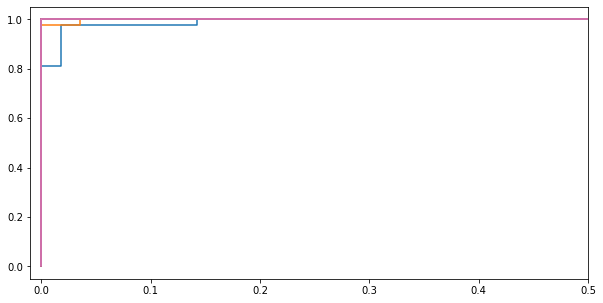

In [134]:
fig, ax = plt.subplots(figsize=(10, 5))
for sensitivity, specificy, _ in res_sensitivity_specificity_auc:
    ax.plot(1.-specificy, sensitivity)
ax.set_xlim((-0.01, 0.5));

The results for every fold are saved in a separate file

In [135]:
write_rocs_to_csvs(res_sensitivity_specificity_auc, subject_unaware_output_path)

Quick check: every index made into the validation set exactly once.

In [136]:
# the indexes in the validation sets in all the folds
i_validation_aggregated = sum([e[1] for e in res_indexes], [])

# every element in the above list is different, and the number of elements is exactly the overall number of samples
assert len(i_validation_aggregated) == len(np.unique(i_validation_aggregated)) == len(df)

The sizes of the training and validation sets in every fold

In [137]:
folds_df = pd.DataFrame([[len(i_t), len(i_v)] for i_t, i_v in res_indexes], columns=['training', 'validation'])
folds_df

,training,validation
0,546,98
1,546,98
2,546,98
3,546,98
4,560,84
5,560,84
6,560,84


The number of samples per subject and that of folds for cross-validation may yield an odd number of samples (from every subject) in the validation set.

In [138]:
n_samples_per_subject = grouped_by_subject.size()['size'].iloc[0]
n_samples_per_subject / n_folds_cross_validation

6.571428571428571

If that's the case, we will not have the same number of healthy and ill examples (for every subject) nor in the training set

In [139]:
grouped_by_subject.nth(i_train.tolist()).groupby(['subject', 'ill']).size()

subject  ill  
0        False    20
         True     20
1        False    20
         True     20
2        False    20
                  ..
11       True     20
12       False    20
         True     20
13       False    20
         True     20
Length: 28, dtype: int64

nor in the validation set

In [140]:
grouped_by_subject.nth(i_valid.tolist()).groupby(['subject', 'ill']).size()

subject  ill  
0        False    3
         True     3
1        False    3
         True     3
2        False    3
                 ..
11       True     3
12       False    3
         True     3
13       False    3
         True     3
Length: 28, dtype: int64

(numbers above refer to the last fold since we are using the last state of the above loop).

## Aware vs. Unaware

In [141]:
always_relevant_features = subject_aware_common_features.intersection(subject_unaware_common_features)
always_relevant_features

{'GPDC/alpha ch. O1 to O2',
 'GPDC/theta ch. O1 to O2',
 'dDTF/beta ch. O1 to C3',
 'dDTF/beta ch. T4 to C3',
 'dDTF/gamma ch. T3 to C3',
 'dDTF/theta ch. Fz to O2',
 'dDTF/theta ch. Pz to P4'}

*Left-over* colors

In [142]:
features_importance_manager.colors

{'YellowOrange', 'blue', 'red'}